# Mask Detection Using YOLOv8 # 

## Imports


In [1]:
pip install "ultralytics<=8.3.40"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.5/898.5 kB 15.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 81.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.1 MB/s eta 0:00:00:00:0100:01
  Attempting u

In [2]:
pip uninstall -y ray

Found existing installation: ray 2.47.1
Uninstalling ray-2.47.1:
  Successfully uninstalled ray-2.47.1
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import os
from PIL import Image
import glob
import xml.etree.ElementTree as ET 
import json
import glob
import ultralytics
from ultralytics import YOLO
import random
import shutil
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import FileLink

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## Modle Loading

In [4]:
model = YOLO('yolov8n.pt')

100%|██████████| 6.25M/6.25M [00:00<00:00, 80.5MB/s]


## Helper Functions

In [5]:
annotations_path = "/kaggle/input/face-mask-detection/annotations"
images_path = "/kaggle/input/face-mask-detection/images"
output_dir = "/kaggle/working/labels/train"

In [6]:
# ========== BBOX CONVERSIONS ==========

def xml_to_yolo_bbox(bbox, w, h):
    x_center = ((bbox[2] + bbox[0]) / 2) / w
    y_center = ((bbox[3] + bbox[1]) / 2) / h
    width = (bbox[2] - bbox[0]) / w
    height = (bbox[3] - bbox[1]) / h
    return [x_center, y_center, width, height]

def yolo_to_xml_bbox(bbox, w, h):
    w_half_len = (bbox[2] * w) / 2
    h_half_len = (bbox[3] * h) / 2
    xmin = int((bbox[0] * w) - w_half_len)
    ymin = int((bbox[1] * h) - h_half_len)
    xmax = int((bbox[0] * w) + w_half_len)
    ymax = int((bbox[1] * h) + h_half_len)
    return [xmin, ymin, xmax, ymax]

# ========== CLASS LIST ==========

CLASSES = ['without_mask', 'with_mask', 'mask_weared_incorrect']

# ========== XML TO YOLO .TXT PARSER ==========

def parse_file(file, output_dir, classes=CLASSES):
    result = []
    tree = ET.parse(file)
    root = tree.getroot()
    width = int(root.find("size/width").text)
    height = int(root.find("size/height").text)

    for obj in root.findall("object"):
        label = obj.find("name").text
        if label not in classes:
            continue  # Skip unknown classes

        index = classes.index(label)
        bndbox = obj.find("bndbox")
        pil_bbox = [
            int(bndbox.find("xmin").text),
            int(bndbox.find("ymin").text),
            int(bndbox.find("xmax").text),
            int(bndbox.find("ymax").text)
        ]
        yolo_bbox = xml_to_yolo_bbox(pil_bbox, width, height)
        bbox_string = " ".join([str(x) for x in yolo_bbox])
        result.append(f"{index} {bbox_string}")

    if result:
        filename = os.path.splitext(os.path.basename(file))[0]
        with open(os.path.join(output_dir, f"{filename}.txt"), "w", encoding="utf-8") as f:
            f.write("\n".join(result))

# ========== EXTRACT BASE FILE NAMES ==========

def extract_file_names(images_path):
    names = []
    for i in os.listdir(images_path):
        if i.lower().endswith((".jpg", ".jpeg", ".png")):
            name = os.path.splitext(i)[0]
            names.append(name)
    return names

# ========== CONSTRUCT YOLO DATASET STRUCTURE ==========

def Construct_dataset(file_names):
    base = "/kaggle/working/data"
    subdirs = ["train/images", "train/labels", "val/images", "val/labels", "test/images", "test/labels"]
    for subdir in subdirs:
        os.makedirs(os.path.join(base, subdir), exist_ok=True)

    random.seed(42)
    random.shuffle(file_names)

    total = len(file_names)
    train_size = int(total * 0.7)
    val_size = int(total * 0.15)
    test_size = total - train_size - val_size

    Train_files = file_names[:train_size]
    Val_files = file_names[train_size:train_size + val_size]
    Test_files = file_names[train_size + val_size:]

    def copy_files(file_list, split):
        for file in file_list:
            img_src = f"/kaggle/input/face-mask-detection/images/{file}.png"
            label_src = f"/kaggle/working/labels/{file}.txt"

            img_dst = f"/kaggle/working/data/{split}/images/{file}.png"
            label_dst = f"/kaggle/working/data/{split}/labels/{file}.txt"

            try:
                shutil.copy(img_src, img_dst)
                shutil.copy(label_src, label_dst)
            except FileNotFoundError as e:
                print(f"Warning: {e}")

    copy_files(Train_files, "train")
    copy_files(Val_files, "val")
    copy_files(Test_files, "test")

    return Train_files, Val_files, Test_files

# ========== ANALYZE YOLOv8 TRAINING METRICS ==========

def analyze_latest_yolo_run(runs_dir="runs/detect"):
    subdirs = [os.path.join(runs_dir, d) for d in os.listdir(runs_dir) if os.path.isdir(os.path.join(runs_dir, d))]
    if not subdirs:
        print("No runs found in", runs_dir)
        return

    latest_run = max(subdirs, key=os.path.getmtime)
    print(f"Latest run directory: {latest_run}")

    results_path = os.path.join(latest_run, "results.csv")
    if not os.path.exists(results_path):
        print("results.csv not found in", latest_run)
        return

    df = pd.read_csv(results_path)
    df.columns = df.columns.str.strip()

    print("Available columns:", df.columns.tolist())
    possible_map_cols = [col for col in df.columns if "mAP" in col]

    if not possible_map_cols:
        print("No mAP column found.")
        return

    map_col = possible_map_cols[0]
    best_epoch = df[map_col].idxmax()
    best_row = df.loc[best_epoch]
    print(f"\n🏆 Best Epoch: {best_epoch}")
    print(best_row)

    plt.figure(figsize=(10, 5))
    plt.plot(df["epoch"], df[map_col], label=map_col, marker='o')
    for col in ["train/box_loss", "train/cls_loss", "val/box_loss", "val/cls_loss"]:
        if col in df.columns:
            plt.plot(df["epoch"], df[col], label=col)
    plt.xlabel("Epoch")
    plt.ylabel("Metric")
    plt.title("YOLO Training Metrics")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



## Prepare Dataset

In [7]:
os.makedirs(output_dir,exist_ok=True)
if not os.path.isdir(output_dir):
    os.makedirs(output_dir)

In [8]:
# ========== EXECUTION ==========

annotations_path = "/kaggle/input/face-mask-detection/annotations"
images_path = "/kaggle/input/face-mask-detection/images"
output_dir = "/kaggle/working/labels"


xml_files = glob.glob(os.path.join(annotations_path, "*.xml"))

for xml_file in xml_files:
    filename = os.path.splitext(os.path.basename(xml_file))[0]
    image_file = os.path.join(images_path, f"{filename}.png")
    if not os.path.exists(image_file):
        print(f"⚠️ Image not found for {filename}, skipping.")
        continue
    parse_file(xml_file, output_dir)



In [9]:

file_names = extract_file_names(images_path)
Train_files, Val_files, Test_files = Construct_dataset(file_names)

## Train Model

In [10]:

# ========== CREATE YAML FILE FOR TRAINING ==========

yaml_content = f"""
path: /kaggle/working/data
train: train/images
val: val/images
test: test/images

nc: {len(CLASSES)}
names: {CLASSES}
"""

with open('/kaggle/working/data.yaml', 'w') as f:
    f.write(yaml_content)

print("✅ Dataset preparation complete.")


✅ Dataset preparation complete.


In [11]:
model.train(data='/kaggle/working/data.yaml', epochs=50, imgsz=640)

New https://pypi.org/project/ultralytics/8.3.173 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.40 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=

100%|██████████| 755k/755k [00:00<00:00, 16.5MB/s]
E0000 00:00:1754143316.204286      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754143316.314893      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 66.8MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/data/train/labels... 597 images, 0 backgrounds, 0 corrupt: 100%|██████████| 597/597 [00:01<00:00, 492.55it/s]


train: New cache created: /kaggle/working/data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.11/dist-packages/ultralytics/data/augment.py:1850: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning /kaggle/working/data/val/labels... 127 images, 0 backgrounds, 0 corrupt: 100%|██████████| 127/127 [00:00<00:00, 531.49it/s]

val: New cache created: /kaggle/working/data/val/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      3.87G      1.825      2.967      1.448        170        640:  89%|████████▉ | 34/38 [00:09<00:01,  3.75it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
       1/50      3.92G      1.771      2.839      1.411         19        640: 100%|██████████| 38/38 [00:10<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.14it/s]

                   all        127        565     0.0125      0.462      0.266      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         3G      1.345      1.552      1.109        134        640:  82%|████████▏ | 31/38 [00:07<00:01,  4.31it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
       2/50      3.31G      1.364      1.536      1.107         93        640: 100%|██████████| 38/38 [00:08<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.72it/s]

                   all        127        565       0.42      0.263      0.319      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      3.24G      1.316      1.296      1.077        235        640:  37%|███▋      | 14/38 [00:02<00:05,  4.47it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
       3/50      3.27G      1.291      1.281       1.06         20        640: 100%|██████████| 38/38 [00:08<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.73it/s]


                   all        127        565      0.776      0.379      0.353      0.211

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.86G      1.292      1.139      1.057        109        640:  37%|███▋      | 14/38 [00:02<00:05,  4.62it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
       4/50       2.9G      1.279      1.139       1.06         29        640: 100%|██████████| 38/38 [00:08<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.89it/s]

                   all        127        565      0.807      0.427      0.511      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.49G       1.27       1.14      1.054        167        640:  34%|███▍      | 13/38 [00:02<00:05,  4.43it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
       5/50      3.42G      1.281      1.097      1.062         50        640: 100%|██████████| 38/38 [00:08<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.75it/s]

                   all        127        565       0.88      0.478      0.557       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.57G      1.244      1.023       1.05        147        640:  63%|██████▎   | 24/38 [00:05<00:03,  3.59it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
       6/50      2.78G      1.237      1.009      1.044         47        640: 100%|██████████| 38/38 [00:08<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.98it/s]


                   all        127        565      0.791      0.537      0.581      0.373

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.19G      1.129     0.9309      1.023        124        640:  18%|█▊        | 7/38 [00:01<00:05,  5.27it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
       7/50      2.58G      1.159     0.9204      1.021         24        640: 100%|██████████| 38/38 [00:07<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.52it/s]


                   all        127        565      0.713      0.535      0.578      0.375

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.77G      1.204     0.9319      1.021        133        640:  66%|██████▌   | 25/38 [00:04<00:02,  4.80it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
       8/50      2.81G      1.185     0.9286      1.025         16        640: 100%|██████████| 38/38 [00:07<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.99it/s]


                   all        127        565      0.538      0.491      0.561      0.369

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.94G      1.203     0.8791      1.025         79        640:  82%|████████▏ | 31/38 [00:06<00:01,  4.60it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
       9/50      2.98G        1.2     0.8765      1.024         85        640: 100%|██████████| 38/38 [00:07<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.83it/s]

                   all        127        565      0.748      0.557      0.634      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50       2.2G       1.13     0.8113      0.972        117        640:   3%|▎         | 1/38 [00:00<00:05,  7.25it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      10/50      2.72G       1.15     0.8581      1.017         64        640: 100%|██████████| 38/38 [00:07<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.17it/s]

                   all        127        565      0.702      0.602      0.654      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.37G      1.142      0.807      1.019         82        640:  39%|███▉      | 15/38 [00:02<00:04,  4.75it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      11/50      2.94G      1.155     0.8053      1.014         37        640: 100%|██████████| 38/38 [00:07<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  25%|██▌       | 1/4 [00:00<00:00,  3.74it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.20it/s]

                   all        127        565      0.484      0.576      0.559      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50       2.9G      1.123     0.7914      1.003         26        640: 100%|██████████| 38/38 [00:08<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.35it/s]

                   all        127        565      0.647      0.626      0.673      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.38G      1.147     0.7844          1        114        640:  66%|██████▌   | 25/38 [00:05<00:02,  4.39it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      13/50      2.42G      1.146     0.7808      1.003         97        640: 100%|██████████| 38/38 [00:08<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.09it/s]

                   all        127        565      0.633      0.547      0.607      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.74G      1.126     0.7429     0.9993        139        640:  92%|█████████▏| 35/38 [00:07<00:00,  3.62it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      14/50      2.79G      1.124     0.7442      0.999         55        640: 100%|██████████| 38/38 [00:08<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.07it/s]

                   all        127        565      0.668      0.626      0.643      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.21G       1.04     0.7052     0.9712        113        640:   5%|▌         | 2/38 [00:00<00:05,  6.57it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      15/50      2.38G      1.104     0.7365     0.9993         78        640: 100%|██████████| 38/38 [00:08<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.73it/s]

                   all        127        565      0.633      0.582      0.631      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.78G      1.066     0.7153      0.992        174        640:  34%|███▍      | 13/38 [00:02<00:05,  4.31it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      16/50      2.82G      1.079     0.7095     0.9924         18        640: 100%|██████████| 38/38 [00:08<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.29it/s]

                   all        127        565       0.85      0.616      0.725      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.49G      1.085     0.6992     0.9814         90        640:  74%|███████▎  | 28/38 [00:06<00:02,  3.75it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      17/50      2.53G      1.086     0.7027     0.9841         34        640: 100%|██████████| 38/38 [00:08<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.07it/s]

                   all        127        565       0.85      0.638      0.729      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.52G      1.106     0.7037     0.9919        109        640:  82%|████████▏ | 31/38 [00:06<00:01,  4.17it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      18/50      2.56G      1.105      0.707     0.9955         50        640: 100%|██████████| 38/38 [00:08<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.35it/s]

                   all        127        565      0.803      0.669      0.755      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.35G      1.056     0.6988      1.005         94        640:  34%|███▍      | 13/38 [00:02<00:06,  3.83it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      19/50      2.39G      1.053     0.6712     0.9874         18        640: 100%|██████████| 38/38 [00:08<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.14it/s]

                   all        127        565      0.842      0.651      0.758      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.62G      1.088     0.6827      0.974        210        640:  66%|██████▌   | 25/38 [00:05<00:03,  4.04it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      20/50      2.67G      1.078     0.6742     0.9742         23        640: 100%|██████████| 38/38 [00:08<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.51it/s]

                   all        127        565      0.744       0.71      0.767      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.85G      1.048     0.6482     0.9722        120        640:  47%|████▋     | 18/38 [00:03<00:04,  4.29it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      21/50      2.88G      1.052     0.6468     0.9706         43        640: 100%|██████████| 38/38 [00:08<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.92it/s]


                   all        127        565       0.81      0.678      0.753      0.507

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.62G       1.05      0.658          1         96        640:  24%|██▎       | 9/38 [00:01<00:05,  5.48it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      22/50      2.92G      1.047     0.6544     0.9808         31        640: 100%|██████████| 38/38 [00:08<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.75it/s]

                   all        127        565      0.831      0.691      0.768      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.31G      1.104     0.6663     0.9731         94        640:  11%|█         | 4/38 [00:00<00:05,  6.33it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      23/50      2.65G      1.049     0.6355     0.9707         37        640: 100%|██████████| 38/38 [00:08<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.04it/s]


                   all        127        565       0.86       0.65      0.763      0.497

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.51G      1.005       0.61     0.9643        167        640:  42%|████▏     | 16/38 [00:03<00:05,  4.06it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      24/50      2.97G      1.039     0.6318     0.9704         26        640: 100%|██████████| 38/38 [00:08<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.70it/s]

                   all        127        565      0.844      0.638       0.75      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.68G      1.068     0.6286      0.956        135        640:  21%|██        | 8/38 [00:01<00:05,  5.17it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      25/50      2.72G      1.043     0.6189     0.9618        130        640: 100%|██████████| 38/38 [00:08<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.16it/s]

                   all        127        565      0.912      0.632      0.783      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.83G      1.037     0.6195      0.958         91        640:  79%|███████▉  | 30/38 [00:06<00:01,  4.04it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      26/50      2.87G      1.036     0.6123     0.9536         37        640: 100%|██████████| 38/38 [00:08<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.19it/s]

                   all        127        565      0.903      0.685      0.797      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.58G      1.023     0.6009     0.9546        100        640:  66%|██████▌   | 25/38 [00:05<00:02,  4.47it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      27/50      2.62G      1.013     0.5943     0.9542         41        640: 100%|██████████| 38/38 [00:08<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.61it/s]


                   all        127        565      0.845      0.675      0.778      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.65G      1.021     0.5924     0.9581        128        640:  89%|████████▉ | 34/38 [00:07<00:00,  4.56it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      28/50      2.69G      1.019     0.5923     0.9575         39        640: 100%|██████████| 38/38 [00:08<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.81it/s]

                   all        127        565      0.904      0.669      0.774      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.32G      1.012     0.5858     0.9538        124        640:  34%|███▍      | 13/38 [00:02<00:05,  4.23it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      29/50       2.5G       1.01     0.5825     0.9565         22        640: 100%|██████████| 38/38 [00:08<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.73it/s]


                   all        127        565      0.815      0.649      0.755      0.512

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.35G     0.9738     0.5668     0.9534        128        640:  84%|████████▍ | 32/38 [00:06<00:01,  4.04it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      30/50      2.81G     0.9835     0.5695       0.95         73        640: 100%|██████████| 38/38 [00:08<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.93it/s]

                   all        127        565      0.843      0.707      0.787      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.73G     0.9673      0.556     0.9448         62        640: 100%|██████████| 38/38 [00:08<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.25it/s]

                   all        127        565      0.758      0.771      0.804      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50         3G      1.016     0.5844     0.9532         80        640:  92%|█████████▏| 35/38 [00:07<00:00,  3.90it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      32/50      3.04G      1.014     0.5814      0.955         33        640: 100%|██████████| 38/38 [00:08<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.22it/s]

                   all        127        565      0.761      0.697      0.776      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.54G     0.9903     0.5573     0.9406         96        640:  68%|██████▊   | 26/38 [00:05<00:02,  4.14it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      33/50      2.81G     0.9859     0.5587     0.9416         19        640: 100%|██████████| 38/38 [00:08<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.53it/s]

                   all        127        565      0.793      0.701      0.774      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50       2.2G     0.9757     0.5373     0.9372         71        640:  26%|██▋       | 10/38 [00:01<00:05,  4.68it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      34/50      2.92G     0.9795     0.5604     0.9453         18        640: 100%|██████████| 38/38 [00:08<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.92it/s]

                   all        127        565      0.854      0.708      0.773      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.17G     0.9919      0.558     0.9589        121        640:  18%|█▊        | 7/38 [00:01<00:07,  4.40it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      35/50       2.7G     0.9713     0.5481     0.9478         37        640: 100%|██████████| 38/38 [00:08<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.43it/s]

                   all        127        565      0.849      0.678      0.777      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.24G     0.9494     0.5308     0.9436        123        640:  37%|███▋      | 14/38 [00:02<00:04,  5.04it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      36/50      2.39G     0.9384     0.5293     0.9464         41        640: 100%|██████████| 38/38 [00:08<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.31it/s]

                   all        127        565      0.761       0.73      0.793       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.84G     0.9759     0.5309     0.9453        150        640:  32%|███▏      | 12/38 [00:02<00:05,  4.58it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      37/50      2.88G     0.9669     0.5334     0.9362         66        640: 100%|██████████| 38/38 [00:08<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.01it/s]

                   all        127        565      0.829      0.693      0.791      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.96G     0.9705     0.5515     0.9361         81        640:  58%|█████▊    | 22/38 [00:04<00:03,  4.00it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      38/50      3.01G     0.9711     0.5468     0.9335         33        640: 100%|██████████| 38/38 [00:08<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.84it/s]

                   all        127        565      0.843      0.727      0.811       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.87G     0.9348     0.5138     0.9343        100        640:  76%|███████▋  | 29/38 [00:06<00:02,  3.91it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      39/50      2.91G     0.9275     0.5099     0.9375         36        640: 100%|██████████| 38/38 [00:08<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.23it/s]

                   all        127        565      0.839      0.758       0.82      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50       2.4G     0.9094     0.5045     0.9271         25        640: 100%|██████████| 38/38 [00:08<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.35it/s]

                   all        127        565      0.841      0.685        0.8      0.549


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.11/dist-packages/ultralytics/data/augment.py:1850: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.55G     0.9449     0.5081     0.9279         50        640:  74%|███████▎  | 28/38 [00:07<00:01,  5.12it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      41/50      2.59G     0.9286     0.4956     0.9243          8        640: 100%|██████████| 38/38 [00:09<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.13it/s]


                   all        127        565      0.863      0.688      0.808      0.541

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.84G     0.9104     0.4856     0.9127         70        640:  89%|████████▉ | 34/38 [00:07<00:00,  4.73it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      42/50      2.84G     0.9051     0.4815     0.9134         41        640:  95%|█████████▍| 36/38 [00:07<00:00,  4.61it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      42/50      2.88G     0.9022     0.4822     0.9143         19        640: 100%|██████████| 38/38 [00:08<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.26it/s]

                   all        127        565      0.842      0.698        0.8      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.73G     0.8812     0.4546     0.9144          8        640: 100%|██████████| 38/38 [00:08<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.98it/s]

                   all        127        565      0.877      0.668      0.788      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.83G     0.9271     0.4752     0.9205         59        640:  53%|█████▎    | 20/38 [00:04<00:04,  4.15it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      44/50      2.87G     0.9062     0.4726     0.9196         13        640: 100%|██████████| 38/38 [00:08<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.12it/s]

                   all        127        565      0.827      0.714      0.814       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.65G     0.8997     0.4722      0.914         59        640:  71%|███████   | 27/38 [00:05<00:02,  3.76it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      45/50      2.69G     0.8882     0.4655      0.914         17        640: 100%|██████████| 38/38 [00:08<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.19it/s]

                   all        127        565       0.79      0.736      0.812      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.67G     0.8831     0.4604     0.9137          8        640: 100%|██████████| 38/38 [00:08<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.00it/s]

                   all        127        565      0.856      0.694      0.806      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.61G     0.8846     0.4548     0.9115         72        640:  37%|███▋      | 14/38 [00:02<00:05,  4.66it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      47/50      2.65G      0.877     0.4498     0.9034         16        640: 100%|██████████| 38/38 [00:08<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.90it/s]

                   all        127        565      0.871      0.689      0.797      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.24G     0.7614     0.4271     0.8894         62        640:   3%|▎         | 1/38 [00:00<00:05,  6.61it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      48/50      2.84G     0.8725     0.4479     0.9055         19        640: 100%|██████████| 38/38 [00:08<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.15it/s]

                   all        127        565      0.863      0.702      0.813      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.75G     0.8661     0.4505     0.8848        160        640:  21%|██        | 8/38 [00:01<00:05,  5.43it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      49/50      2.79G     0.8749     0.4451     0.9062         17        640: 100%|██████████| 38/38 [00:08<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.98it/s]

                   all        127        565      0.856      0.698      0.808      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.19G     0.8749     0.4332     0.9039         65        640:  13%|█▎        | 5/38 [00:00<00:05,  6.42it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      50/50      2.67G     0.8689     0.4518     0.9039         26        640: 100%|██████████| 38/38 [00:08<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.17it/s]

                   all        127        565      0.797      0.728      0.802      0.554



50 epochs completed in 0.145 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.40 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.42it/s]


                   all        127        565      0.827      0.713      0.814      0.559
          without_mask         50        106      0.781       0.74      0.815      0.531
             with_mask        114        431      0.894      0.898      0.943      0.669
 mask_weared_incorrect         21         28      0.807        0.5      0.683      0.476


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.2ms preprocess, 3.4ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e735c314410>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

## Model Results

Latest run directory: runs/detect/train
Available columns: ['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']

🏆 Best Epoch: 38
epoch                    39.000000
time                    405.841000
train/box_loss            0.927500
train/cls_loss            0.509900
train/dfl_loss            0.937530
metrics/precision(B)      0.839420
metrics/recall(B)         0.757800
metrics/mAP50(B)          0.820390
metrics/mAP50-95(B)       0.545280
val/box_loss              1.028770
val/cls_loss              0.613570
val/dfl_loss              1.004720
lr/pg0                    0.000354
lr/pg1                    0.000354
lr/pg2                    0.000354
Name: 38, dtype: float64


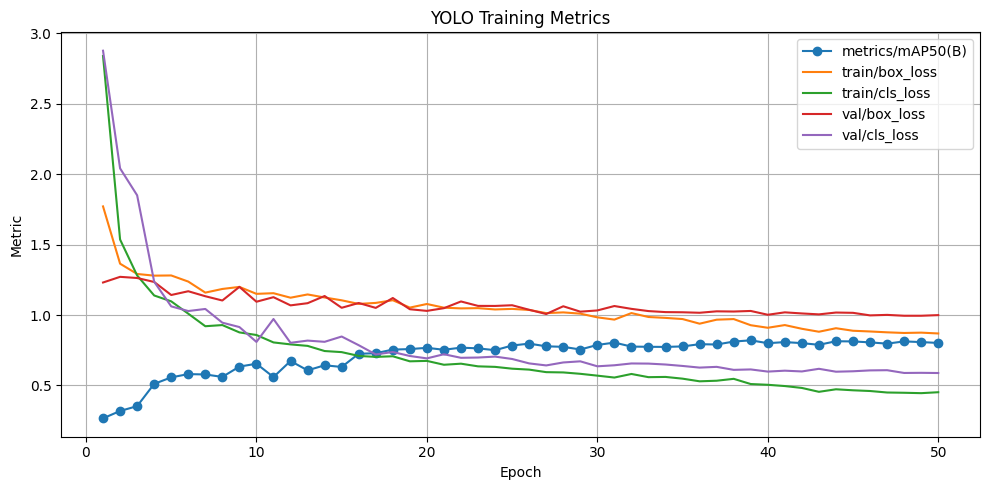

In [12]:
analyze_latest_yolo_run()

In [13]:
results = model.val(data='data.yaml', conf=0.25)


Ultralytics 8.3.40 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /kaggle/working/data/val/labels.cache... 127 images, 0 backgrounds, 0 corrupt: 100%|██████████| 127/127 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.61it/s]


                   all        127        565      0.816      0.714      0.807      0.593
          without_mask         50        106      0.782      0.743      0.821      0.586
             with_mask        114        431      0.894      0.899      0.937      0.702
 mask_weared_incorrect         21         28      0.773        0.5      0.662       0.49


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.3ms preprocess, 9.5ms inference, 0.0ms loss, 5.0ms postprocess per image
Results saved to runs/detect/train2


In [14]:
ultralytics.checks()

Ultralytics 8.3.40 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 6411.5/8062.4 GB disk)


## Model testing

In [15]:
model_predict = YOLO("/kaggle/working/runs/detect/train/weights/best.pt")

In [16]:
# Detection
model_predict.predict("/kaggle/working/data/test/images/maksssksksss222.png", save=True)


image 1/1 /kaggle/working/data/test/images/maksssksksss222.png: 384x640 2 without_masks, 18 with_masks, 41.6ms
Speed: 1.9ms preprocess, 41.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'without_mask', 1: 'with_mask', 2: 'mask_weared_incorrect'}
 obb: None
 orig_img: array([[[220, 216, 201],
         [228, 224, 209],
         [228, 224, 209],
         ...,
         [  3,   4,   4],
         [  1,   3,   3],
         [  0,   3,   3]],
 
        [[220, 216, 201],
         [228, 224, 209],
         [228, 224, 209],
         ...,
         [  2,   4,   4],
         [  1,   3,   3],
         [  0,   3,   3]],
 
        [[225, 221, 206],
         [232, 228, 213],
         [234, 230, 215],
         ...,
         [  0,   3,   3],
         [  1,   3,   3],
         [  0,   3,   3]],
 
        ...,
 
        [[147, 157, 162],
         [138, 148, 157],
         [153, 157, 164],
         ...,
         [115, 175, 197],
         [ 35,  46,  56],
         [  3,   0,   0]],
 
        [[149, 159, 163],
         [147, 157, 167],
        

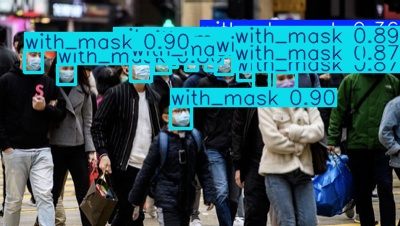

In [17]:
# Detection Result
Image.open("/kaggle/working/runs/detect/predict/maksssksksss222.jpg")

## Save Best Epoch

In [ ]:
# Get the latest run directory
latest_run_dir = get_latest_yolo_run()
print(f"📁 Latest training run: {latest_run_dir}")


In [19]:
best_model_path = "runs/detect/train/weights/best.pt"
os.path.exists(best_model_path)

True

In [20]:
FileLink(best_model_path)

/kaggle/working/runs/detect/train/weights/best.pt